<h1>Walmart Sales Forecasting--Modeling</h1>

In [1]:
#Importing Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import dask.dataframe as dk
import calendar
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,Normalizer
from xgboost import XGBRegressor
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor
import catboost as cat
from sklearn.ensemble import AdaBoostRegressor
import pickle

In [2]:
#this snippet of code is used to reduce memory consumption by dataframe
dtype={'id'       :     'object', 
    'item_id'     :  'int64', 
    'dept_id'     :  'int8', 
    'cat_id'      :  'int8', 
    'store_id'    :  'int8', 
    'state_id'    :  'int8', 
    'd'           :  'object', 
    'sales'       :  'int16',  
    'date'        : 'object', 
   'wday'        :  'int8',  
   'month'       :  'int8',  
   'year'        :  'int16',  
   'event_name_1' : 'int8', 
   'event_type_1' : 'int8', 
   'event_name_2' : 'int8', 
   'event_type_2' : 'int8', 
    'snap':'int8',
  'sell_price'   : 'float16',
       'price_change':'float16',
   'week_number'  : 'int8',  
   'season'       : 'object', 
   'quater_start' : 'int8',  
   'quater_end'   : 'int8',  
   'month_start'  : 'int8',  
   'month_end'    : 'int8',  
   'year_start'   : 'int8',  
   'year_end'     : 'int8',  
   'group'        : 'int8',  
   'no_events'    : 'object', 
   'holiday'      : 'object',
    'week_number':'int8',
       'season':'int8',
       'quater_start':'int8',
       'quater_end':'int8',
       'month_start':'int8',
       'month_end':'int8',
       'year_start':'int8',
       'year_end':'int8',
       'roll_7_shift_28_mean':'float16',
       'roll_14_shift_28_mean':'float16',
       'roll_30_shift_28_mean':'float16',
       'roll_60_shift_28_mean':'float16',
       'roll_360_shift_28_mean':'float16',
       'roll_7_shift_28_std':'float16',
       'roll_14_shift_28_std':'float16',
       'roll_30_shift_28_std':'float16',
       'roll_60_shift_28_std':'float16',
       'roll_360_shift_28_std':'float16',
       'direct_ewm':'float16',
       'direct_lag_28':'int16',
       'direct_lag_35':'int16',
       'direct_lag_42':'int16',
       'direct_lag_49':'int16',
       'direct_lag_56':'int16',
       'direct_lag_63':'int16',
       'direct_lag_70':'int16',
       'direct_lag_77':'int16',
       'direct_lag_84':'int16',
       'direct_lag_91':'int16',
       'direct_lag_98':'int16',
       'min_price':'float16',
       'max_price':'float16',
       'mean_price':'float16',
       'std_price':'float16',
       'price_norm_1':'float16',
       'price_norm_2':'float16',
       'price_norm_3':'float16',
      }

In [3]:
train=pd.read_csv('train1.csv',dtype=dtype)
cv=pd.read_csv('cv1.csv',dtype=dtype)
test=pd.read_csv('test1.csv',dtype=dtype)
final_test=pd.read_csv('final_test1.csv',dtype=dtype)

<h3>Metric Calculation Functions</h3>

In [21]:
def caluclate_WRMSSE(actual,predicted,train,weights,h,n):
    '''This function is used to calculate RMSSE'''
    num=((actual-predicted)**2).sum(axis=1)/h
    denom=(train[:,1:]-train[:,:-1])**2
    denom=denom.sum(axis=1)/(n-1)
    return (num/denom)**0.5

In [22]:
#Refrernce https://www.kaggle.com/qcw171717/naive-baseline/ 
def get_model_performances(model,train,cv,test,X_cv,X_test):
    '''This Function is used to get WRMSSE that is used in this Case Study as a Metric For CV and Test Data'''
    #For CV Data
    cv['prices']=cv['sales']*cv['sell_price']
    total_sales=cv.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i]=total_sales.loc[i]['sales']/total
    train1=pd.concat([train,cv])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    cv['pred_sales']=model.predict(X_cv)
    df1=cv.pivot_table(index=['id'],columns='d',values='pred_sales')
    dic={}
    for j,i in enumerate(range(1886,1914)):
        dic['d_'+str(i)]='F'+str(j+1)
    df1=df1.rename(columns=dic) 
    df1.reset_index(level=[0],inplace=True)
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1914)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12    
    agg=agg.append(dd[col])
    actual=agg[['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1886)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1886)
    cv_wrsmme=np.sum(rmsse*weights)
    cv.drop(['pred_sales'],axis=1,inplace=True)
    del actual,predicted,training,weights,agg
    
    #For Test data
    test['prices']=test['sales']*test['sell_price']
    total_sales=test.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i.replace('evaluation','validation')]=total_sales.loc[i]['sales']/total
    test['id']=test['id'].apply(lambda x:x.replace('evaluation','validation'))
    train1=pd.concat([train,cv,test])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    test['pred_sales']=model.predict(X_test)
    df1=test.pivot_table(index=['id'],columns='d',values='pred_sales')
    dic={}
    for j,i in enumerate(range(1914,1942)):
        dic['d_'+str(i)]='F'+str(j+1)
    df1=df1.rename(columns=dic) 
    df1.reset_index(level=[0],inplace=True)
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1942)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12    
    agg=agg.append(dd[col])
    actual=agg[['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919',
       'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925',
       'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931',
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937',
       'd_1938', 'd_1939', 'd_1940', 'd_1941']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1914)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1914)
    test_wrsmme=np.sum(rmsse*weights)

    print("CV WRMSSE=",cv_wrsmme)
    print("Test WRMSSE=",test_wrsmme)
    

In [39]:
#https://www.kaggle.com/qcw171717/naive-baseline/ 
def get_model_performances_for_store_wise_trained_model(train,cv,test,cv_pred,test_pred):
    '''This Function is used to get WRMSSE that is used in this Case Study as a Metric For CV and Test Data where model is trained according to store id(Mainly used for Catabosst)'''
    #For CV Data
    cv['prices']=cv['sales']*cv['sell_price']
    total_sales=cv.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i]=total_sales.loc[i]['sales']/total
    train1=pd.concat([train,cv])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    
    df1=cv_pred
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1914)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12    
    agg=agg.append(dd[col])
    actual=agg[['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1886)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1886)
    cv_wrsmme=np.sum(rmsse*weights)
    del actual,predicted,training,weights,agg
    
    #For Test data
    test['prices']=test['sales']*test['sell_price']
    total_sales=test.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i.replace('evaluation','validation')]=total_sales.loc[i]['sales']/total
    test['id']=test['id'].apply(lambda x:x.replace('evaluation','validation'))
    train1=pd.concat([train,cv,test])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    df1=test_pred
    df1['id']=df1['id'].apply(lambda x:x.replace('evaluation','validation'))
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1942)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12    
    agg=agg.append(dd[col])
    actual=agg[['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919',
       'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925',
       'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931',
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937',
       'd_1938', 'd_1939', 'd_1940', 'd_1941']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1914)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1914)
    test_wrsmme=np.sum(rmsse*weights)

    print("CV WRMSSE=",cv_wrsmme)
    print("Test WRMSSE=",test_wrsmme)
    

<h1>Modeling</h1>

<h2>1. LSTM Network(No Date Features)</h2>

In [ ]:
#several Reference Ideas taken from https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164374

In [8]:
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(10)(input10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(input10)

x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item_Id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Dept_Id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cat_Id (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Store_Id (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

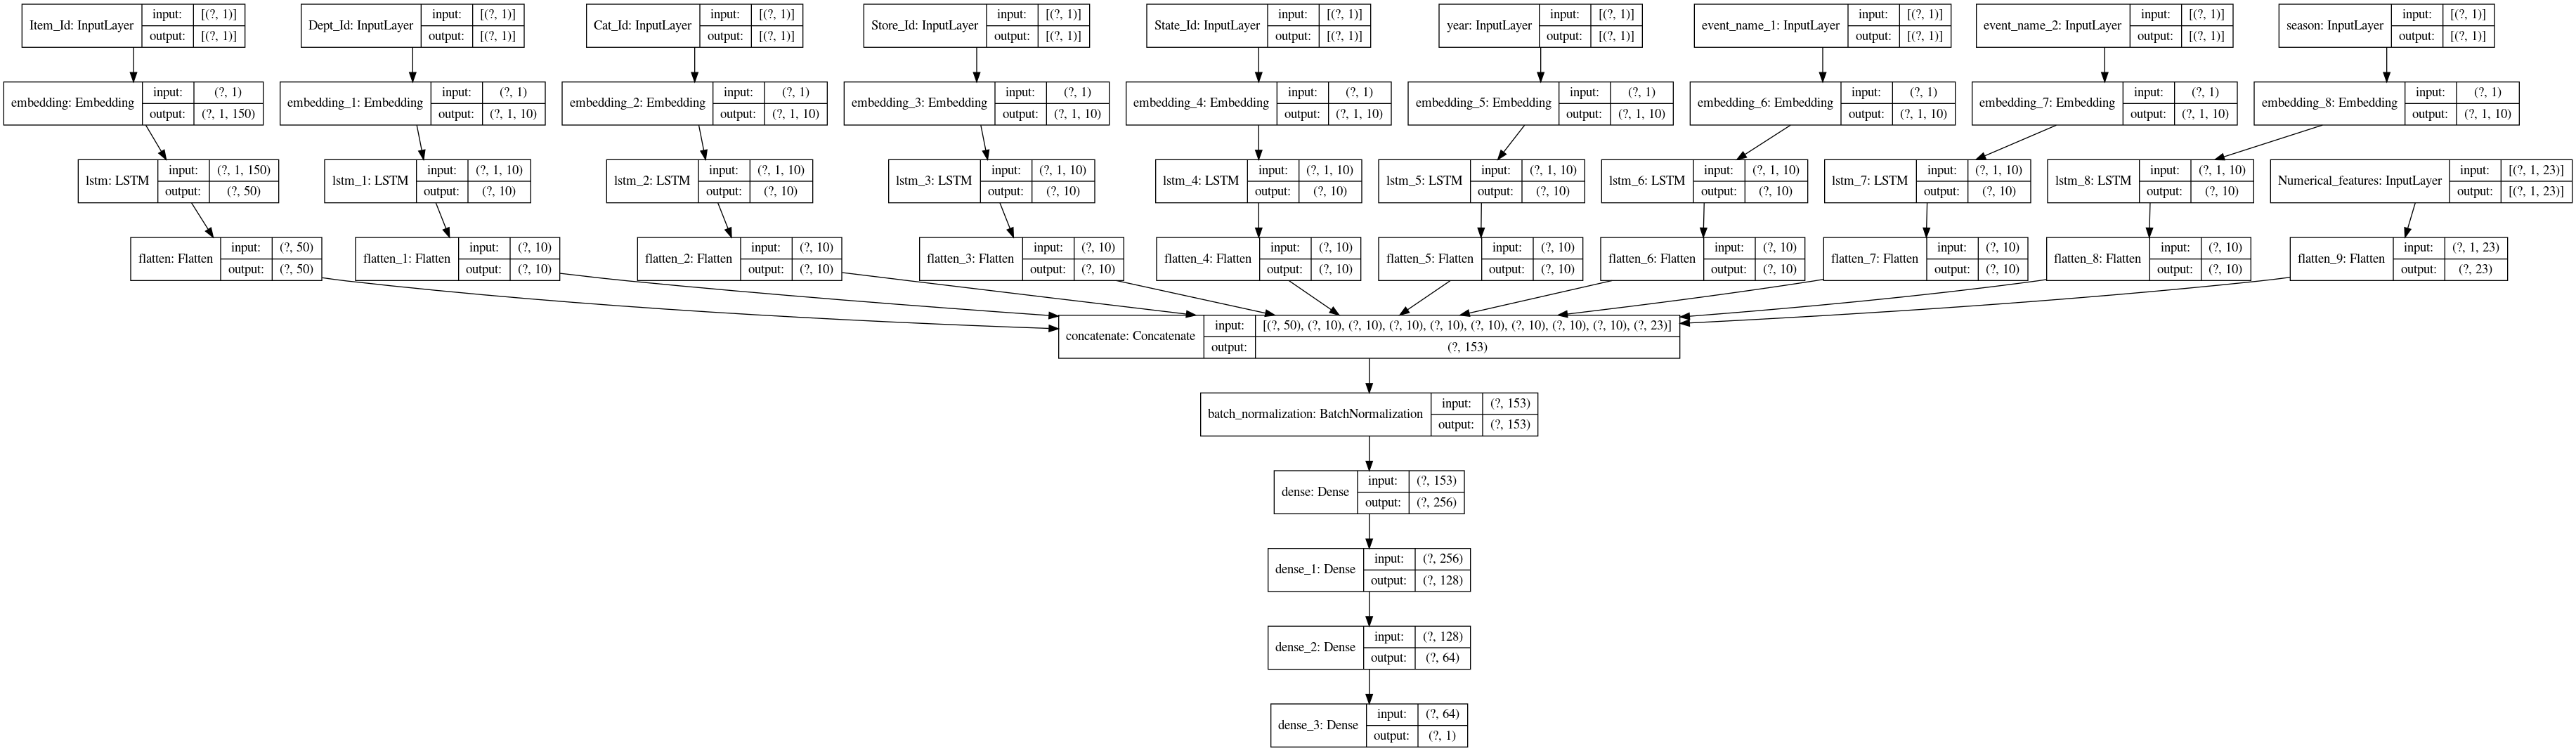

In [10]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0009),loss='mse')

In [12]:
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=15,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),workers=5,use_multiprocessing=True)

Train on 45174237 samples, validate on 853720 samples
Epoch 1/15
45174237/45174237 [==============================] - 636s 14us/sample - loss: 8.7152 - val_loss: 4.9377
Epoch 2/15
45174237/45174237 [==============================] - 609s 13us/sample - loss: 7.5126 - val_loss: 4.9375
Epoch 3/15
45174237/45174237 [==============================] - 608s 13us/sample - loss: 7.2318 - val_loss: 4.8140
Epoch 4/15
45174237/45174237 [==============================] - 607s 13us/sample - loss: 7.0534 - val_loss: 4.7979
Epoch 5/15
45174237/45174237 [==============================] - 608s 13us/sample - loss: 6.9097 - val_loss: 4.8065
Epoch 6/15
45174237/45174237 [==============================] - 610s 13us/sample - loss: 6.8050 - val_loss: 4.8488
Epoch 7/15
45174237/45174237 [==============================] - 609s 13us/sample - loss: 6.7098 - val_loss: 4.8210
Epoch 8/15
45174237/45174237 [==============================] - 607s 13us/sample - loss: 6.6371 - val_loss: 4.8313
Epoch 9/15
45174237/451742

In [13]:
%%time
get_model_performances(model,train,cv,test,[cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
                       [test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

CV WRMSSE= 0.9364420581545198
Test WRMSSE= 0.8766403828582977
CPU times: user 21min 50s, sys: 12min 39s, total: 34min 30s
Wall time: 9min 55s


<h3>Now We try to Submit It in Required Format for Kaggle</h3>

In [23]:
#Predicting for test data
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

In [24]:
#predicting sales for final_test data
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

In [25]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)    

CPU times: user 1.35 s, sys: 580 ms, total: 1.93 s
Wall time: 907 ms


In [26]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 736 ms, sys: 4 ms, total: 740 ms
Wall time: 737 ms


In [27]:
df2=pd.concat([df1,df])

In [28]:
#We have then submitted this Csv file in kaggle to get scores
df2.to_csv('NN.csv',index=False)

<img src='images/NN.PNG'>

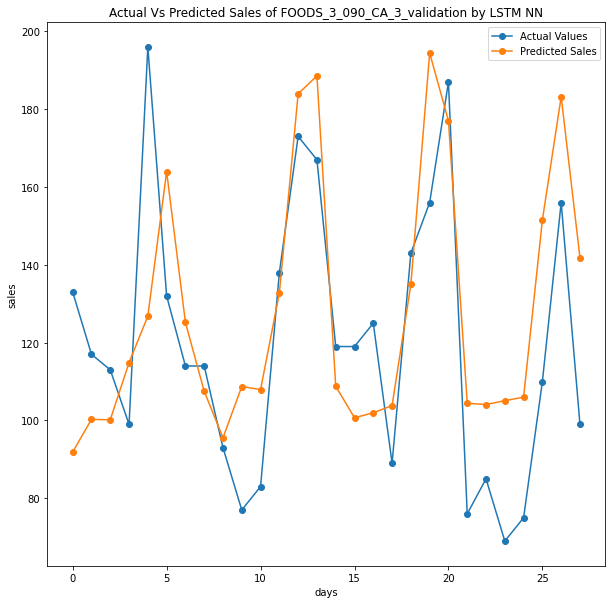

In [69]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('NN.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by LSTM NN")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

<h2>2. CNN-LSTM NN(No Date Features)</h2>

In [ ]:
#Several Reference Ideas taken from https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164374

In [14]:
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb1=tf.keras.layers.Conv1D(7,8,padding='same',activation='relu')(emb1)

emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb2=tf.keras.layers.Conv1D(3,8,padding='same',activation='sigmoid')(emb2)

emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb3=tf.keras.layers.Conv1D(5,8,padding='same',activation='relu')(emb3)

emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb4=tf.keras.layers.Conv1D(5,8,padding='same',activation='tanh')(emb4)

emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb5=tf.keras.layers.Conv1D(5,8,padding='same',activation='relu')(emb5)

emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb6=tf.keras.layers.Conv1D(5,8,padding='same',activation='sigmoid')(emb6)

emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb7=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb7)

emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb8=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb8)

emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)
emb9=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb9)

emb10=tf.keras.layers.Conv1D(3,16,padding='same',activation='tanh')(input10)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(32)(emb10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(lstm10)


x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item_Id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Dept_Id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cat_Id (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Store_Id (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

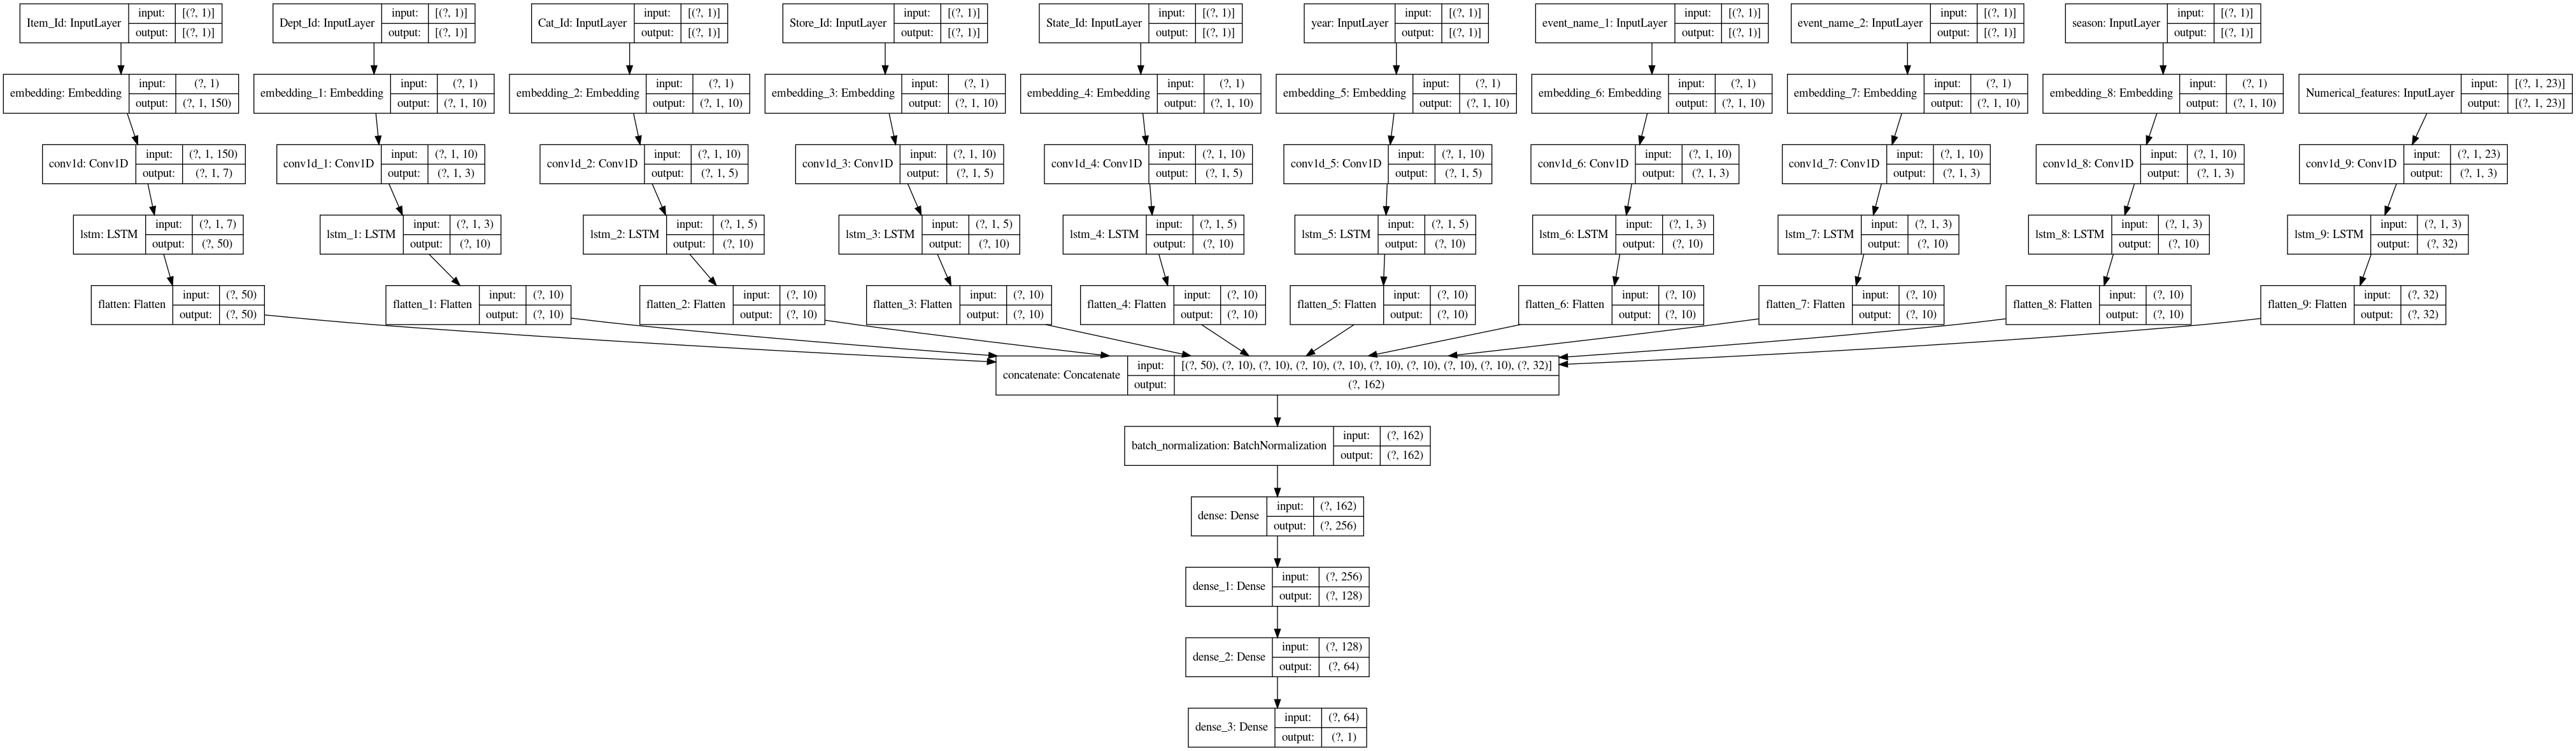

In [16]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss='mse')

In [18]:
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=10,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),use_multiprocessing=True,workers=7)

Train on 45174237 samples, validate on 853720 samples
Epoch 1/10
45174237/45174237 [==============================] - 1228s 27us/sample - loss: 9.1670 - val_loss: 5.0257
Epoch 2/10
45174237/45174237 [==============================] - 1195s 26us/sample - loss: 7.9768 - val_loss: 5.0183
Epoch 3/10
45174237/45174237 [==============================] - 1199s 27us/sample - loss: 7.7540 - val_loss: 5.1179
Epoch 4/10
45174237/45174237 [==============================] - 1199s 27us/sample - loss: 7.5851 - val_loss: 5.4407
Epoch 5/10
45174237/45174237 [==============================] - 1195s 26us/sample - loss: 7.4587 - val_loss: 4.9926
Epoch 6/10
45174237/45174237 [==============================] - 1189s 26us/sample - loss: 7.3759 - val_loss: 5.0490
Epoch 7/10
45174237/45174237 [==============================] - 1187s 26us/sample - loss: 7.3030 - val_loss: 4.9501
Epoch 8/10
45174237/45174237 [==============================] - 1185s 26us/sample - loss: 7.2826 - val_loss: 5.0241
Epoch 9/10
4517423

In [19]:
%%time
get_model_performances(model,train,cv,test,[cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
                       [test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

CV WRMSSE= 0.9316142875533537
Test WRMSSE= 0.9638282313741626
CPU times: user 29min 2s, sys: 16min 28s, total: 45min 30s
Wall time: 11min 13s


<h3>Now We try to Submit It in Required Format for Kaggle</h3>

In [39]:
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

In [40]:
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

In [41]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)    

CPU times: user 1.36 s, sys: 568 ms, total: 1.93 s
Wall time: 882 ms


In [42]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 692 ms, sys: 40 ms, total: 732 ms
Wall time: 729 ms


In [43]:
df2=pd.concat([df1,df])

In [44]:
df2.to_csv('CNN.csv',index=False)

<img src="images/CNNLSTM.PNG">

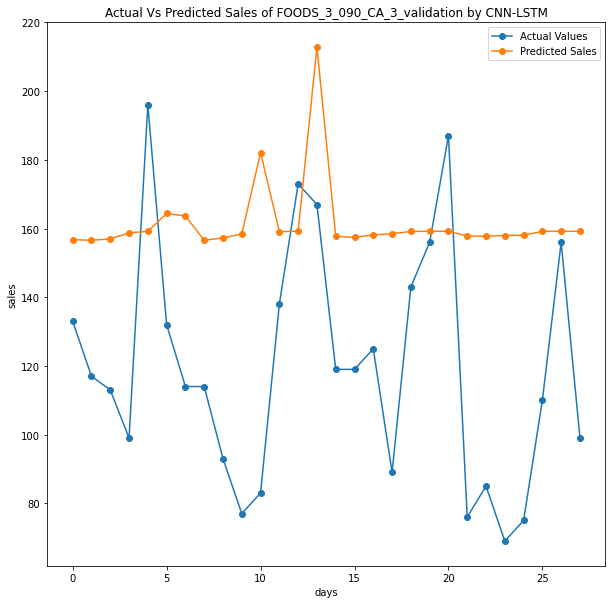

In [64]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('CNN.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by CNN-LSTM")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

<h3>Peparing Training ,Crossvalidation ,Test and Final Test sparse matrix to used while modeling(For Linear Regression,adaboost Regressor)</h3>

In [5]:
#Code Snippet to prepare data for serveral Models in which we pass sparse matrix
#converting item_id into string so that it can be used by Count Vectorizer
train['item_id']=train['item_id'].apply(lambda x:str(x))
cv['item_id']=cv['item_id'].apply(lambda x:str(x))
test['item_id']=test['item_id'].apply(lambda x:str(x))
final_test['item_id']=final_test['item_id'].apply(lambda x:str(x))


vec_item_id=CountVectorizer(binary=True)
train_id=vec_item_id.fit_transform(train['item_id'])
train_season=csr_matrix(tf.keras.utils.to_categorical(train['season'],4))
train_month=csr_matrix(tf.keras.utils.to_categorical(train['month'],13))
train_wday=csr_matrix(tf.keras.utils.to_categorical(train['wday'],8))
train_snap=csr_matrix(tf.keras.utils.to_categorical(train['snap'],2))
train_dept=csr_matrix(tf.keras.utils.to_categorical(train['dept_id'],7))
train_en1=csr_matrix(tf.keras.utils.to_categorical(train['event_name_1'],31))
train_en2=csr_matrix(tf.keras.utils.to_categorical(train['event_name_2'],5))
train_et1=csr_matrix(tf.keras.utils.to_categorical(train['event_type_1'],5))
train_et2=csr_matrix(tf.keras.utils.to_categorical(train['event_type_2'],3))
train_yr=csr_matrix(tf.keras.utils.to_categorical(train['year'],6))
train_yr_st=csr_matrix(tf.keras.utils.to_categorical(train['year_start'],2))
train_yr_end=csr_matrix(tf.keras.utils.to_categorical(train['year_end'],2))
train_qt_st=csr_matrix(tf.keras.utils.to_categorical(train['quater_start'],2))
train_qt_end=csr_matrix(tf.keras.utils.to_categorical(train['quater_end'],2))
train_month_st=csr_matrix(tf.keras.utils.to_categorical(train['month_start'],2))
train_month_end=csr_matrix(tf.keras.utils.to_categorical(train['month_end'],2))

cv_id=vec_item_id.transform(cv['item_id'])
cv_season=csr_matrix(tf.keras.utils.to_categorical(cv['season'],4))
cv_month=csr_matrix(tf.keras.utils.to_categorical(cv['month'],13))
cv_wday=csr_matrix(tf.keras.utils.to_categorical(cv['wday'],8))
cv_snap=csr_matrix(tf.keras.utils.to_categorical(cv['snap'],2))
cv_dept=csr_matrix(tf.keras.utils.to_categorical(cv['dept_id'],7))
cv_en1=csr_matrix(tf.keras.utils.to_categorical(cv['event_name_1'],31))
cv_en2=csr_matrix(tf.keras.utils.to_categorical(cv['event_name_2'],5))
cv_et1=csr_matrix(tf.keras.utils.to_categorical(cv['event_type_1'],5))
cv_et2=csr_matrix(tf.keras.utils.to_categorical(cv['event_type_2'],3))
cv_yr=csr_matrix(tf.keras.utils.to_categorical(cv['year'],6))
cv_yr_st=csr_matrix(tf.keras.utils.to_categorical(cv['year_start'],2))
cv_yr_end=csr_matrix(tf.keras.utils.to_categorical(cv['year_end'],2))
cv_qt_st=csr_matrix(tf.keras.utils.to_categorical(cv['quater_start'],2))
cv_qt_end=csr_matrix(tf.keras.utils.to_categorical(cv['quater_end'],2))
cv_month_st=csr_matrix(tf.keras.utils.to_categorical(cv['month_start'],2))
cv_month_end=csr_matrix(tf.keras.utils.to_categorical(cv['month_end'],2))


test_id=vec_item_id.transform(test['item_id'])
test_season=csr_matrix(tf.keras.utils.to_categorical(test['season'],4))
test_month=csr_matrix(tf.keras.utils.to_categorical(test['month'],13))
test_wday=csr_matrix(tf.keras.utils.to_categorical(test['wday'],8))
test_snap=csr_matrix(tf.keras.utils.to_categorical(test['snap'],2))
test_dept=csr_matrix(tf.keras.utils.to_categorical(test['dept_id'],7))
test_en1=csr_matrix(tf.keras.utils.to_categorical(test['event_name_1'],31))
test_en2=csr_matrix(tf.keras.utils.to_categorical(test['event_name_2'],5))
test_et1=csr_matrix(tf.keras.utils.to_categorical(test['event_type_1'],5))
test_et2=csr_matrix(tf.keras.utils.to_categorical(test['event_type_2'],3))
test_yr=csr_matrix(tf.keras.utils.to_categorical(test['year'],6))
test_yr_st=csr_matrix(tf.keras.utils.to_categorical(test['year_start'],2))
test_yr_end=csr_matrix(tf.keras.utils.to_categorical(test['year_end'],2))
test_qt_st=csr_matrix(tf.keras.utils.to_categorical(test['quater_start'],2))
test_qt_end=csr_matrix(tf.keras.utils.to_categorical(test['quater_end'],2))
test_month_st=csr_matrix(tf.keras.utils.to_categorical(test['month_start'],2))
test_month_end=csr_matrix(tf.keras.utils.to_categorical(test['month_end'],2))


final_test_id=vec_item_id.transform(final_test['item_id'])
final_test_season=csr_matrix(tf.keras.utils.to_categorical(final_test['season'],4))
final_test_month=csr_matrix(tf.keras.utils.to_categorical(final_test['month'],13))
final_test_wday=csr_matrix(tf.keras.utils.to_categorical(final_test['wday'],8))
final_test_snap=csr_matrix(tf.keras.utils.to_categorical(final_test['snap'],2))
final_test_dept=csr_matrix(tf.keras.utils.to_categorical(final_test['dept_id'],7))
final_test_en1=csr_matrix(tf.keras.utils.to_categorical(final_test['event_name_1'],31))
final_test_en2=csr_matrix(tf.keras.utils.to_categorical(final_test['event_name_2'],5))
final_test_et1=csr_matrix(tf.keras.utils.to_categorical(final_test['event_type_1'],5))
final_test_et2=csr_matrix(tf.keras.utils.to_categorical(final_test['event_type_2'],3))
final_test_yr=csr_matrix(tf.keras.utils.to_categorical(final_test['year'],6))
final_test_yr_st=csr_matrix(tf.keras.utils.to_categorical(final_test['year_start'],2))
final_test_yr_end=csr_matrix(tf.keras.utils.to_categorical(final_test['year_end'],2))
final_test_qt_st=csr_matrix(tf.keras.utils.to_categorical(final_test['quater_start'],2))
final_test_qt_end=csr_matrix(tf.keras.utils.to_categorical(final_test['quater_end'],2))
final_test_month_st=csr_matrix(tf.keras.utils.to_categorical(final_test['month_start'],2))
final_test_month_end=csr_matrix(tf.keras.utils.to_categorical(final_test['month_end'],2))

X_train=hstack((train_id,train_dept,train_month,train_wday,train_yr,\
                train_snap,train_en1,train_en2,train_et1,train_et2,train_yr_st,train_yr_end,
                train_qt_st,train_qt_end,train_month_st,train_month_end,\
                train['direct_lag_28'].values.reshape(-1,1),
                train['direct_lag_35'].values.reshape(-1,1),train['direct_lag_42'].values.reshape(-1,1),\
                train['direct_lag_49'].values.reshape(-1,1),train['direct_lag_56'].values.reshape(-1,1),\
                train['direct_lag_63'].values.reshape(-1,1),train['direct_lag_70'].values.reshape(-1,1),\
                train['direct_lag_77'].values.reshape(-1,1),train['direct_lag_84'].values.reshape(-1,1),\
                train['direct_lag_91'].values.reshape(-1,1),train['direct_lag_98'].values.reshape(-1,1),\
                train['sell_price'].values.reshape(-1,1))).tocsr()
y_train=train['sales'].values

X_cv=hstack((cv_id,cv_dept,cv_month,cv_wday,cv_yr,\
                cv_snap,cv_en1,cv_en2,cv_et1,cv_et2,cv_yr_st,cv_yr_end,
                cv_qt_st,cv_qt_end,cv_month_st,cv_month_end,\
             cv['direct_lag_28'].values.reshape(-1,1),
                cv['direct_lag_35'].values.reshape(-1,1),cv['direct_lag_42'].values.reshape(-1,1),\
                cv['direct_lag_49'].values.reshape(-1,1),cv['direct_lag_56'].values.reshape(-1,1),\
                cv['direct_lag_63'].values.reshape(-1,1),cv['direct_lag_70'].values.reshape(-1,1),\
                cv['direct_lag_77'].values.reshape(-1,1),cv['direct_lag_84'].values.reshape(-1,1),\
                cv['direct_lag_91'].values.reshape(-1,1),cv['direct_lag_98'].values.reshape(-1,1),\
                cv['sell_price'].values.reshape(-1,1)
                )).tocsr()
y_cv=cv['sales'].values


X_test=hstack((test_id,test_dept,test_month,test_wday,test_yr,\
                test_snap,test_en1,test_en2,test_et1,test_et2,test_yr_st,test_yr_end,
                test_qt_st,test_qt_end,test_month_st,test_month_end,\
                test['direct_lag_28'].values.reshape(-1,1),
                test['direct_lag_35'].values.reshape(-1,1),test['direct_lag_42'].values.reshape(-1,1),\
                test['direct_lag_49'].values.reshape(-1,1),test['direct_lag_56'].values.reshape(-1,1),\
                test['direct_lag_63'].values.reshape(-1,1),test['direct_lag_70'].values.reshape(-1,1),\
                test['direct_lag_77'].values.reshape(-1,1),test['direct_lag_84'].values.reshape(-1,1),\
                test['direct_lag_91'].values.reshape(-1,1),test['direct_lag_98'].values.reshape(-1,1),\
                test['sell_price'].values.reshape(-1,1))).tocsr()
y_test=test['sales'].values

X_final_test=hstack((final_test_id,final_test_dept,final_test_month,final_test_wday,final_test_yr,\
                final_test_snap,final_test_en1,final_test_en2,final_test_et1,final_test_et2,final_test_yr_st,final_test_yr_end,
                final_test_qt_st,final_test_qt_end,final_test_month_st,final_test_month_end,\
               final_test['direct_lag_28'].values.reshape(-1,1),
                final_test['direct_lag_35'].values.reshape(-1,1),final_test['direct_lag_42'].values.reshape(-1,1),\
                final_test['direct_lag_49'].values.reshape(-1,1),final_test['direct_lag_56'].values.reshape(-1,1),\
                final_test['direct_lag_63'].values.reshape(-1,1),final_test['direct_lag_70'].values.reshape(-1,1),\
                final_test['direct_lag_77'].values.reshape(-1,1),final_test['direct_lag_84'].values.reshape(-1,1),\
                final_test['direct_lag_91'].values.reshape(-1,1),final_test['direct_lag_98'].values.reshape(-1,1),\
                final_test['sell_price'].values.reshape(-1,1))).tocsr()
y_final_test=final_test['sales'].values

<h2> 3.Linear Regression(Without Rolling Features)</h2>

In [19]:
%%time
#Note here if we give data by normalizing numerical features too the model performance was same
reg=LinearRegression(n_jobs=7,normalize=True,)
reg.fit(X_train,y_train)
y_pred_tr=reg.predict(X_train)
y_pred_cv=reg.predict(X_cv)
error_tr=np.sqrt(mean_squared_error(y_train,y_pred_tr))
error_tst=np.sqrt(mean_squared_error(y_cv,y_pred_cv))
print("Linear Regression model")
print("="*15)
print("Train RMSE=",error_tr," CV RMSE=",error_tst)

Linear Regression model
Train RMSE= 2.8460755734258028  CV RMSE= 2.214106105123244
CPU times: user 3min 33s, sys: 38.4 s, total: 4min 11s
Wall time: 3min 11s


In [65]:
%%time
get_model_performances(reg,train,cv,test,X_cv,X_test)

CV WRMSSE= 0.7705590697572734
Test WRMSSE= 1.0985180224869153
CPU times: user 5min 55s, sys: 1min 35s, total: 7min 30s
Wall time: 7min 29s


<h3>Now We try to Submit It in Required Format for Kaggle</h3>

In [20]:
test['pred_sales']=reg.predict(X_test)
final_test['pred_sales']=reg.predict(X_final_test)

In [24]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)    

CPU times: user 756 ms, sys: 48 ms, total: 804 ms
Wall time: 804 ms


In [25]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 872 ms, sys: 12 ms, total: 884 ms
Wall time: 879 ms


In [26]:
df2=pd.concat([df1,df])

In [27]:
df2.to_csv('linear_reg.csv',index=False)

<img src='images/linearRegression.PNG'>

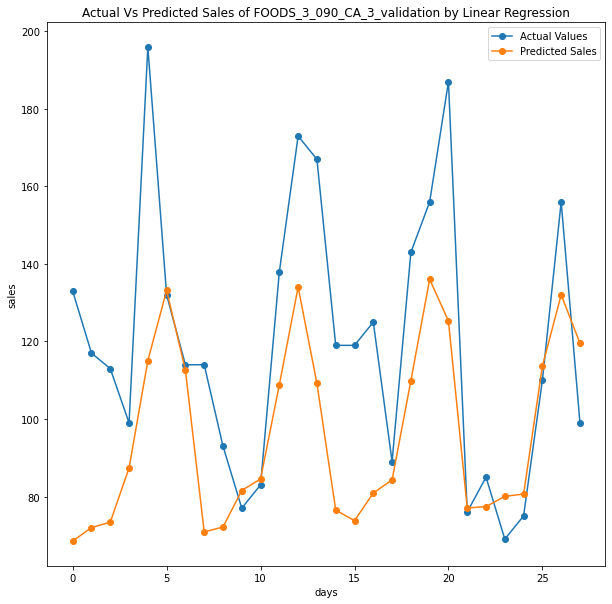

In [70]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('linear_reg.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by Linear Regression")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

<h2>4. Adaboost Regressor(Without Rolling features)</h2>

In [ ]:
#Reference https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [ ]:
#Note here i have used n_estimators=5 bcz error was increasing a lot buy increasing n_estimators

In [17]:
%%time
reg=AdaBoostRegressor(n_estimators=5,learning_rate=0.1,loss='square')
reg.fit(X_train,y_train)
print("Adaboost Regression model")
y_pred_tr=reg.predict(X_train)
y_pred_cv=reg.predict(X_cv)
error_tr=np.sqrt(mean_squared_error(y_train,y_pred_tr))
error_tst=np.sqrt(mean_squared_error(y_cv,y_pred_cv))
print("="*15)
print("Train RMSE=",error_tr," CV RMSE=",error_tst)

Adaboost Regression model
Train RMSE= 3.2221071335541303  CV RMSE= 2.563867059398114
CPU times: user 45min 4s, sys: 1min 25s, total: 46min 30s
Wall time: 46min 30s


In [18]:
%%time
#Get Test and CV RMSSE
get_model_performances(reg,train,cv,test,X_cv,X_test)

CV WRMSSE= 1.1225005526462835
Test WRMSSE= 1.170172795692723
CPU times: user 5min 32s, sys: 1min 17s, total: 6min 49s
Wall time: 6min 49s


<h3>Now We try to Submit It in Required Format for Kaggle</h3>

In [20]:
test['pred_sales']=reg.predict(X_test)
final_test['pred_sales']=reg.predict(X_final_test)

In [21]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)    

CPU times: user 780 ms, sys: 96 ms, total: 876 ms
Wall time: 900 ms


In [22]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 740 ms, sys: 96 ms, total: 836 ms
Wall time: 834 ms


In [23]:
df2=pd.concat([df1,df])

In [24]:
df2.to_csv('adaboost.csv',index=False)

<img src='images/adaboost.PNG'>

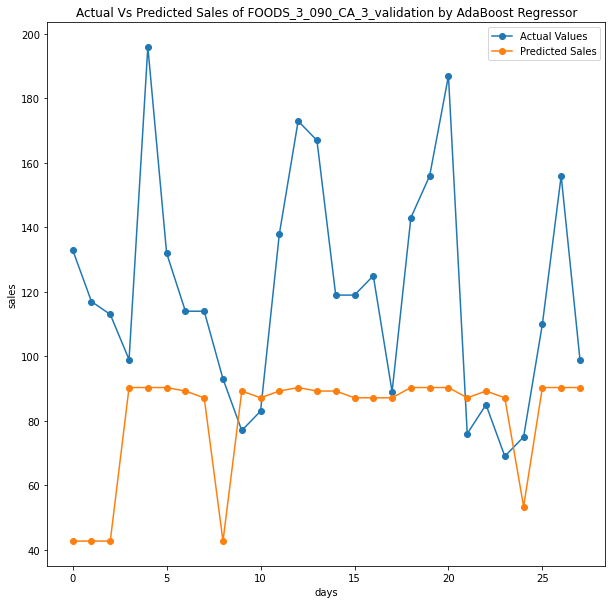

In [71]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('adaboost.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by AdaBoost Regressor")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

<h2> 5.LGBM Regressor(All Features)</h2>

In [ ]:
#References https://lightgbm.readthedocs.io/en/latest/Python-API.html,https://www.kaggle.com/rohitsingh9990/m5-lgbm-fe,https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163684\

In [9]:
#categorical Data's
columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2','snap','week_number', 'quater_start', 'quater_end', 'month_start',
       'month_end', 'year_start', 'year_end','season']

In [10]:
data=lgb.Dataset(train.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1),label=train['sales'],categorical_feature=columns,free_raw_data=False)

In [11]:
data_cv=lgb.Dataset(cv.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1),label=cv['sales'],categorical_feature=columns,free_raw_data=False )

In [12]:
params = {
          "objective" : "tweedie",
            "metric" :"rmse",
            "n_estimators":6000,
            "force_row_wise" : True,
            "learning_rate" : 0.09,
            "nthread" : 8,
            'verbosity': 1,
            'num_iterations' : 1000,
    'tweedie_variance_power': 1.1,
    'max_bin': 127,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 1000,
    'min_data_in_leaf': 2**10-1,
    'learning_rate': 0.05,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'boost_from_average': True,
}


In [13]:
%%time
m_lgb=lgb.train(params,data,verbose_eval=1,valid_sets=[data,data_cv],early_stopping_rounds=5)

[LightGBM] [Info] Total Bins 6049
[LightGBM] [Info] Number of data points in the train set: 45174237, number of used features: 44
[LightGBM] [Info] Start training from score 0.356321
[1]	training's rmse: 4.26681	valid_1's rmse: 3.53775
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 4.20588	valid_1's rmse: 3.47848
[3]	training's rmse: 4.14037	valid_1's rmse: 3.41614
[4]	training's rmse: 4.07154	valid_1's rmse: 3.35173
[5]	training's rmse: 4.00026	valid_1's rmse: 3.28565
[6]	training's rmse: 3.92912	valid_1's rmse: 3.2199
[7]	training's rmse: 3.85781	valid_1's rmse: 3.15421
[8]	training's rmse: 3.78553	valid_1's rmse: 3.08927
[9]	training's rmse: 3.71717	valid_1's rmse: 3.02726
[10]	training's rmse: 3.64831	valid_1's rmse: 2.96612
[11]	training's rmse: 3.58384	valid_1's rmse: 2.90843
[12]	training's rmse: 3.52025	valid_1's rmse: 2.85339
[13]	training's rmse: 3.45959	valid_1's rmse: 2.80285
[14]	training's rmse: 3.40164	valid_1's rmse: 2.75353
[15]	traini

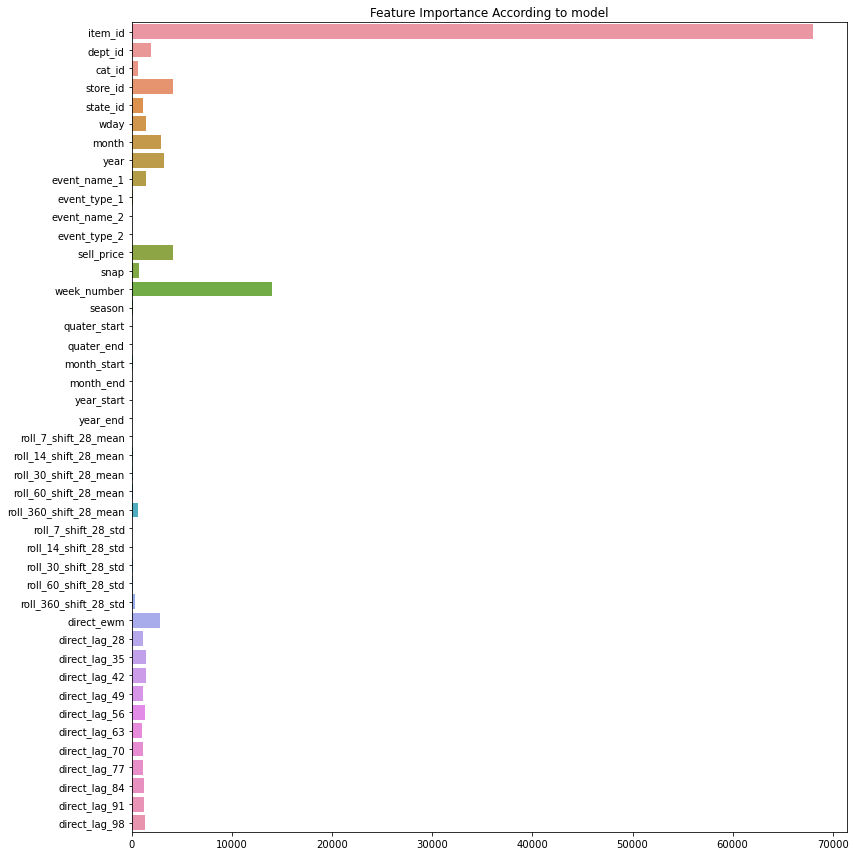

In [14]:
col=train.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1).columns
plt.figure(figsize=(12,12))
sns.barplot(x=m_lgb.feature_importance(),y=col)
plt.title("Feature Importance According to model")
plt.tight_layout()
plt.show()

In [15]:
%%time
get_model_performances(m_lgb,train,cv,test,cv.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1),test.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1))

CV WRMSSE= 0.5665996551497273
Test WRMSSE= 0.7626213228126794
CPU times: user 7min 39s, sys: 1min 35s, total: 9min 14s
Wall time: 7min 5s


<h3>Now We try to Submit It in Required Format for Kaggle</h3>

In [ ]:
test['pred_sales']=m_lgb.predict(test.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1))
final_test['pred_sales']=m_lgb.predict(final_test.drop(['id','sales','date','d','max_price','mean_price','std_price','min_price','price_norm_1',\
                            'price_norm_2','price_norm_3'],axis=1))

In [14]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)    

CPU times: user 956 ms, sys: 4 ms, total: 960 ms
Wall time: 762 ms


In [15]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 688 ms, sys: 0 ns, total: 688 ms
Wall time: 687 ms


In [16]:
df2=pd.concat([df1,df])

In [17]:
df2.to_csv('sample_submission.csv',index=False)

<img src="images/lgbm.PNG">

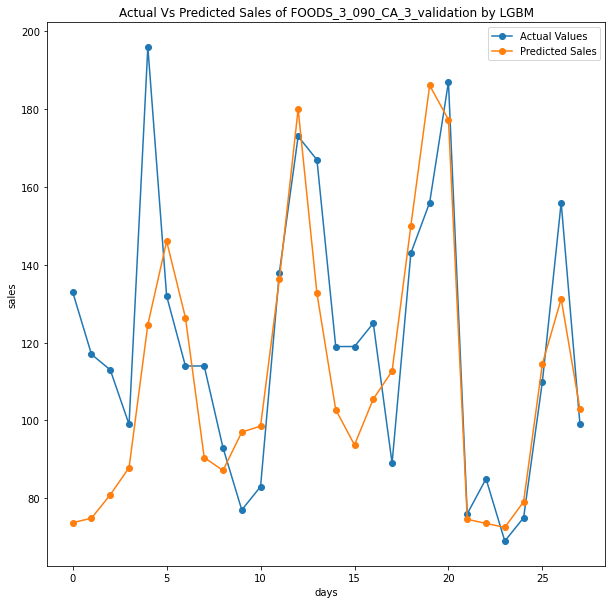

In [72]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('sample_submission.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by LGBM")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

<h2> 6.CatBoost Regressor(All Features)</h2>

<h4>Note Here I am applying Cataboost Regresssor Store wise bcz due to memory constraint we can't fit whole data</h4>

In [ ]:
#Reference for catboost:-https://www.kaggle.com/nicapotato/simple-catboost

In [6]:
categorical=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2','snap','week_number', 'quater_start', 'quater_end', 'month_start',
       'month_end', 'year_start', 'year_end']

In [13]:
#training catabosst regressor for each store

for store in tqdm(range(10)):
    cb_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
    print("="*30)
    print("\nTraining for StoreId",store,"\n\n")
    print("="*30)
    train0=train[train['store_id']==store]
    cv0=cv[cv['store_id']==store]
    cb_model.fit(train0.drop(['id','sales','date'],axis=1),train0['sales'],
             cat_features=categorical,
             eval_set=(cv0.drop(['id','sales','date'],axis=1),cv0['sales']),
             use_best_model=True,
             verbose=1)
    cb_model.save_model("Model_store_id"+str(store))

  0%|          | 0/10 [00:00<?, ?it/s]


Training for StoreId 0 




0:	learn: 4.4342569	test: 3.4410104	best: 3.4410104 (0)	total: 7.91s	remaining: 2h 11m 39s
75:	learn: 3.0049068	test: 2.3407810	best: 2.3407810 (75)	total: 9m 7s	remaining: 1h 50m 55s
150:	learn: 2.6779054	test: 2.2194038	best: 2.2194038 (150)	total: 19m 55s	remaining: 1h 52m
225:	learn: 2.6044709	test: 2.2051399	best: 2.2051327 (224)	total: 30m 10s	remaining: 1h 43m 19s
300:	learn: 2.5602164	test: 2.2084911	best: 2.2016651 (282)	total: 40m 12s	remaining: 1h 33m 21s
375:	learn: 2.5313511	test: 2.2624593	best: 2.2016651 (282)	total: 50m 58s	remaining: 1h 24m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.201665103
bestIteration = 282

Shrink model to first 283 iterations.


 10%|█         | 1/10 [55:33<8:20:01, 3333.53s/it]


Training for StoreId 1 




0:	learn: 3.1248314	test: 3.0575631	best: 3.0575631 (0)	total: 7.45s	remaining: 2h 4m 4s
75:	learn: 2.2935344	test: 2.2198215	best: 2.2198215 (75)	total: 8m 35s	remaining: 1h 44m 29s
150:	learn: 2.1650336	test: 2.1253477	best: 2.1253477 (150)	total: 17m 21s	remaining: 1h 37m 34s
225:	learn: 2.1232864	test: 2.1083713	best: 2.1083043 (224)	total: 26m 55s	remaining: 1h 32m 11s
300:	learn: 2.1025337	test: 2.1074601	best: 2.1064722 (279)	total: 36m 41s	remaining: 1h 25m 13s
375:	learn: 2.0862286	test: 2.1272789	best: 2.1064722 (279)	total: 46m 32s	remaining: 1h 17m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.106472162
bestIteration = 279

Shrink model to first 280 iterations.


 20%|██        | 2/10 [1:45:57<7:12:04, 3240.61s/it]


Training for StoreId 2 




0:	learn: 6.8087826	test: 4.9694918	best: 4.9694918 (0)	total: 6.61s	remaining: 1h 50m
75:	learn: 4.3774116	test: 3.1539455	best: 3.1539455 (75)	total: 8m 55s	remaining: 1h 48m 28s
150:	learn: 3.8270858	test: 2.9321454	best: 2.9321454 (150)	total: 19m 35s	remaining: 1h 50m 7s
225:	learn: 3.6954785	test: 2.9296443	best: 2.9201915 (185)	total: 29m 32s	remaining: 1h 41m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.92019151
bestIteration = 185

Shrink model to first 186 iterations.


 30%|███       | 3/10 [2:27:13<5:51:19, 3011.29s/it]


Training for StoreId 3 




0:	learn: 2.2152742	test: 1.8696242	best: 1.8696242 (0)	total: 6.3s	remaining: 1h 44m 56s
75:	learn: 1.6510335	test: 1.4589321	best: 1.4589321 (75)	total: 9m 20s	remaining: 1h 53m 40s
150:	learn: 1.5634134	test: 1.4283306	best: 1.4283306 (150)	total: 19m 8s	remaining: 1h 47m 36s
225:	learn: 1.5396892	test: 1.4237991	best: 1.4237954 (223)	total: 29m 20s	remaining: 1h 40m 29s
300:	learn: 1.5273632	test: 1.4244697	best: 1.4231561 (252)	total: 39m 48s	remaining: 1h 32m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.423156055
bestIteration = 252

Shrink model to first 253 iterations.


 40%|████      | 4/10 [3:17:47<5:01:49, 3018.23s/it]


Training for StoreId 4 




0:	learn: 3.6383346	test: 3.0348123	best: 3.0348123 (0)	total: 7.89s	remaining: 2h 11m 23s
75:	learn: 2.4597767	test: 1.9749001	best: 1.9749001 (75)	total: 9m 10s	remaining: 1h 51m 26s
150:	learn: 2.2297908	test: 1.8762357	best: 1.8762357 (150)	total: 19m 55s	remaining: 1h 52m 3s
225:	learn: 2.1674535	test: 1.8590310	best: 1.8582650 (209)	total: 30m 33s	remaining: 1h 44m 38s
300:	learn: 2.1354780	test: 1.8629628	best: 1.8564841 (276)	total: 41m 25s	remaining: 1h 36m 12s
375:	learn: 2.1119474	test: 1.8793196	best: 1.8564841 (276)	total: 52m 11s	remaining: 1h 26m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.856484079
bestIteration = 276

Shrink model to first 277 iterations.


 50%|█████     | 5/10 [4:13:45<4:20:00, 3120.10s/it]


Training for StoreId 5 




0:	learn: 4.8327063	test: 3.5026399	best: 3.5026399 (0)	total: 8.07s	remaining: 2h 14m 22s
75:	learn: 3.0327023	test: 2.0031014	best: 2.0031014 (75)	total: 8m 43s	remaining: 1h 45m 59s
150:	learn: 2.7039110	test: 1.9423156	best: 1.9391170 (118)	total: 19m 19s	remaining: 1h 48m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.93911702
bestIteration = 118

Shrink model to first 119 iterations.


 60%|██████    | 6/10 [4:45:51<3:04:07, 2761.77s/it]


Training for StoreId 6 




0:	learn: 4.1772533	test: 3.2512417	best: 3.2512417 (0)	total: 7.79s	remaining: 2h 9m 45s
75:	learn: 2.6377550	test: 1.9799711	best: 1.9799711 (75)	total: 8m 57s	remaining: 1h 48m 48s
150:	learn: 2.3453403	test: 1.9049686	best: 1.9049686 (150)	total: 19m 23s	remaining: 1h 49m 2s
225:	learn: 2.2814483	test: 1.9044098	best: 1.9044098 (225)	total: 28m 50s	remaining: 1h 38m 45s
300:	learn: 2.2394617	test: 1.9183293	best: 1.9039456 (242)	total: 38m 49s	remaining: 1h 30m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.903945641
bestIteration = 242

Shrink model to first 243 iterations.


 70%|███████   | 7/10 [5:34:09<2:20:07, 2802.53s/it]


Training for StoreId 7 




0:	learn: 2.6913632	test: 2.5059131	best: 2.5059131 (0)	total: 7.51s	remaining: 2h 5m 2s
75:	learn: 1.9202715	test: 1.7926018	best: 1.7926018 (75)	total: 9m 13s	remaining: 1h 52m 11s
150:	learn: 1.8082878	test: 1.7332710	best: 1.7332710 (150)	total: 18m 30s	remaining: 1h 44m 6s
225:	learn: 1.7703730	test: 1.7252739	best: 1.7252739 (225)	total: 28m 51s	remaining: 1h 38m 50s
300:	learn: 1.7486895	test: 1.7274353	best: 1.7251296 (229)	total: 39m 17s	remaining: 1h 31m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.72512957
bestIteration = 229

Shrink model to first 230 iterations.


 80%|████████  | 8/10 [6:20:56<1:33:28, 2804.12s/it]


Training for StoreId 8 




0:	learn: 4.2720311	test: 4.8555725	best: 4.8555725 (0)	total: 6.55s	remaining: 1h 49m 8s
75:	learn: 3.0471978	test: 3.4585758	best: 3.4585758 (75)	total: 9m 3s	remaining: 1h 50m 2s
150:	learn: 2.8203555	test: 3.2488172	best: 3.2488172 (150)	total: 18m 36s	remaining: 1h 44m 36s
225:	learn: 2.7257562	test: 3.2121446	best: 3.2113135 (224)	total: 28m 30s	remaining: 1h 37m 36s
300:	learn: 2.6691720	test: 3.2012407	best: 3.1997836 (260)	total: 38m 51s	remaining: 1h 30m 14s
375:	learn: 2.6353051	test: 3.2265716	best: 3.1973177 (321)	total: 49m 10s	remaining: 1h 21m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.19731773
bestIteration = 321

Shrink model to first 322 iterations.


 90%|█████████ | 9/10 [7:19:58<50:25, 3025.27s/it]  


Training for StoreId 9 




0:	learn: 4.4590532	test: 3.7833060	best: 3.7833060 (0)	total: 6.34s	remaining: 1h 45m 38s
75:	learn: 2.8875762	test: 2.3228238	best: 2.3228238 (75)	total: 9m 17s	remaining: 1h 52m 52s
150:	learn: 2.5772767	test: 2.1544316	best: 2.1544316 (150)	total: 19m 40s	remaining: 1h 50m 36s
225:	learn: 2.4931527	test: 2.1266731	best: 2.1266731 (225)	total: 29m 29s	remaining: 1h 40m 58s
300:	learn: 2.4459668	test: 2.1182116	best: 2.1181329 (298)	total: 39m 42s	remaining: 1h 32m 13s
375:	learn: 2.4049116	test: 2.1172706	best: 2.1156157 (355)	total: 50m 18s	remaining: 1h 23m 29s
450:	learn: 2.3481733	test: 2.3232403	best: 2.1150643 (386)	total: 1h 1m 29s	remaining: 1h 14m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.115064321
bestIteration = 386

Shrink model to first 387 iterations.


100%|██████████| 10/10 [8:30:17<00:00, 3061.74s/it]


<h3>Predicting for test and final_test Store wise and then combining whole for required Kaggle Submission</h3>

In [5]:
%%time
#now we try to see how theses models work on test,cv,final_test
test0=test[test['store_id']==0]
test1=test[test['store_id']==1]
test2=test[test['store_id']==2]
test3=test[test['store_id']==3]
test4=test[test['store_id']==4]
test5=test[test['store_id']==5]
test6=test[test['store_id']==6]
test7=test[test['store_id']==7]
test8=test[test['store_id']==8]
test9=test[test['store_id']==9]


cv0=cv[cv['store_id']==0]
cv1=cv[cv['store_id']==1]
cv2=cv[cv['store_id']==2]
cv3=cv[cv['store_id']==3]
cv4=cv[cv['store_id']==4]
cv5=cv[cv['store_id']==5]
cv6=cv[cv['store_id']==6]
cv7=cv[cv['store_id']==7]
cv8=cv[cv['store_id']==8]
cv9=cv[cv['store_id']==9]



final_test0=final_test[final_test['store_id']==0]
final_test1=final_test[final_test['store_id']==1]
final_test2=final_test[final_test['store_id']==2]
final_test3=final_test[final_test['store_id']==3]
final_test4=final_test[final_test['store_id']==4]
final_test5=final_test[final_test['store_id']==5]
final_test6=final_test[final_test['store_id']==6]
final_test7=final_test[final_test['store_id']==7]
final_test8=final_test[final_test['store_id']==8]
final_test9=final_test[final_test['store_id']==9]

CPU times: user 332 ms, sys: 0 ns, total: 332 ms
Wall time: 330 ms


In [6]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id0')
cv0['pred_sales']=reg.predict(cv0.drop(['id','sales','date','d'],axis=1))
test0['pred_sales']=reg.predict(test0.drop(['id','sales','date','d'],axis=1))
final_test0['pred_sales']=reg.predict(final_test0.drop(['id','sales','date','d'],axis=1))

CPU times: user 14.5 s, sys: 312 ms, total: 14.8 s
Wall time: 11.7 s


In [7]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id1')
cv1['pred_sales']=reg.predict(cv1.drop(['id','sales','date','d'],axis=1))
test1['pred_sales']=reg.predict(test1.drop(['id','sales','date','d'],axis=1))
final_test1['pred_sales']=reg.predict(final_test1.drop(['id','sales','date','d'],axis=1))

CPU times: user 15 s, sys: 336 ms, total: 15.3 s
Wall time: 11.7 s


In [8]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id2')
cv2['pred_sales']=reg.predict(cv2.drop(['id','sales','date','d'],axis=1))
test2['pred_sales']=reg.predict(test2.drop(['id','sales','date','d'],axis=1))
final_test2['pred_sales']=reg.predict(final_test2.drop(['id','sales','date','d'],axis=1))

CPU times: user 13.6 s, sys: 80 ms, total: 13.7 s
Wall time: 11.4 s


In [9]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id3')
cv3['pred_sales']=reg.predict(cv3.drop(['id','sales','date','d'],axis=1))
test3['pred_sales']=reg.predict(test3.drop(['id','sales','date','d'],axis=1))
final_test3['pred_sales']=reg.predict(final_test3.drop(['id','sales','date','d'],axis=1))

CPU times: user 15 s, sys: 208 ms, total: 15.2 s
Wall time: 12 s


In [10]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id4')
cv4['pred_sales']=reg.predict(cv4.drop(['id','sales','date','d'],axis=1))
test4['pred_sales']=reg.predict(test4.drop(['id','sales','date','d'],axis=1))
final_test4['pred_sales']=reg.predict(final_test4.drop(['id','sales','date','d'],axis=1))

CPU times: user 15.2 s, sys: 208 ms, total: 15.4 s
Wall time: 11.9 s


In [11]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id5')
cv5['pred_sales']=reg.predict(cv5.drop(['id','sales','date','d'],axis=1))
test5['pred_sales']=reg.predict(test5.drop(['id','sales','date','d'],axis=1))
final_test5['pred_sales']=reg.predict(final_test5.drop(['id','sales','date','d'],axis=1))

CPU times: user 12.9 s, sys: 32 ms, total: 12.9 s
Wall time: 11.4 s


In [12]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id6')
cv6['pred_sales']=reg.predict(cv6.drop(['id','sales','date','d'],axis=1))
test6['pred_sales']=reg.predict(test6.drop(['id','sales','date','d'],axis=1))
final_test6['pred_sales']=reg.predict(final_test6.drop(['id','sales','date','d'],axis=1))

CPU times: user 14.6 s, sys: 176 ms, total: 14.8 s
Wall time: 11.8 s


In [13]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id7')
cv7['pred_sales']=reg.predict(cv7.drop(['id','sales','date','d'],axis=1))
test7['pred_sales']=reg.predict(test7.drop(['id','sales','date','d'],axis=1))
final_test7['pred_sales']=reg.predict(final_test7.drop(['id','sales','date','d'],axis=1))

CPU times: user 15.5 s, sys: 272 ms, total: 15.8 s
Wall time: 12.1 s


In [14]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id8')
cv8['pred_sales']=reg.predict(cv8.drop(['id','sales','date','d'],axis=1))
test8['pred_sales']=reg.predict(test8.drop(['id','sales','date','d'],axis=1))
final_test8['pred_sales']=reg.predict(final_test8.drop(['id','sales','date','d'],axis=1))

CPU times: user 15.6 s, sys: 172 ms, total: 15.8 s
Wall time: 12.3 s


In [15]:
%%time
reg=CatBoostRegressor(iterations=1000,
                             learning_rate=0.02,
                             depth=12,
                            verbose=1,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
reg.load_model('Model_store_id9')
cv9['pred_sales']=reg.predict(cv9.drop(['id','sales','date','d'],axis=1))
test9['pred_sales']=reg.predict(test9.drop(['id','sales','date','d'],axis=1))
final_test9['pred_sales']=reg.predict(final_test9.drop(['id','sales','date','d'],axis=1))

CPU times: user 17.4 s, sys: 324 ms, total: 17.8 s
Wall time: 12.4 s


In [16]:
cv1=pd.concat([cv0,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9])
test1=pd.concat([test0,test1,test2,test3,test4,test5,test6,test7,test8,test9])
final_test1=pd.concat([final_test0,final_test1,final_test2,final_test3,final_test4,final_test5,final_test6,final_test7,final_test8,final_test9])

In [37]:
cv.sort_values(['id','date'],inplace=True)
test.sort_values(['id','date'],inplace=True)
final_test.sort_values(['id','date'],inplace=True)

In [17]:
%%time
df0=cv1.pivot_table(index='id',columns='d',values='pred_sales')
df0.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1886,1914)):
    dic['d_'+str(day)]='F'+str(i+1)
df0.rename(columns=dic,inplace=True) 

CPU times: user 768 ms, sys: 0 ns, total: 768 ms
Wall time: 765 ms


In [18]:
%%time
df=test1.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=['2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
       '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
       '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
       '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
       '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
       '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
       '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22']
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)    

CPU times: user 720 ms, sys: 0 ns, total: 720 ms
Wall time: 718 ms


In [40]:
%%time
# Score by custom WRMSSE Implementation
get_model_performances_for_store_wise_trained_model(train,cv,test,df0,df1)

CV WRMSSE= 0.929778586025316
Test WRMSSE= 0.9289167959162555
CPU times: user 4min 39s, sys: 1min 11s, total: 5min 51s
Wall time: 5min 51s


In [19]:
%%time
df1=final_test1.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 704 ms, sys: 0 ns, total: 704 ms
Wall time: 705 ms


In [57]:
df=pd.concat([df,df1])

In [7]:
df.to_csv('catboost.csv',index=False)

<img src='images/catboost.PNG'>

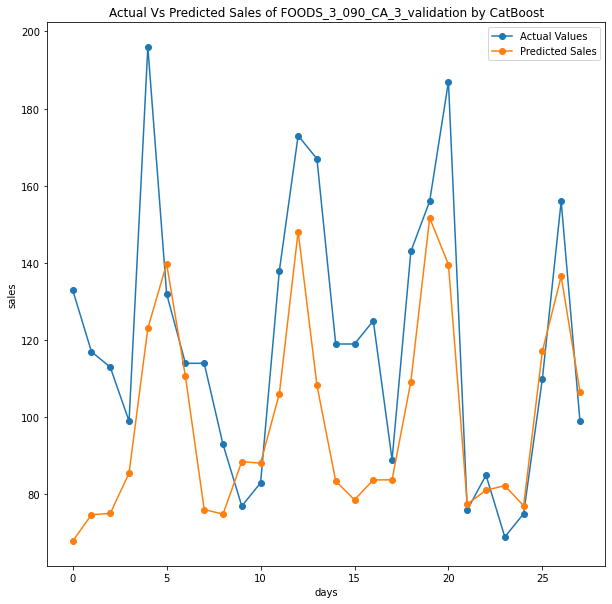

In [73]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('catboost.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by CatBoost")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

<h1>Summary of All Models</h1>

In [43]:
#Summary of All Models
df=pd.DataFrame({'Models':['LSTM Neural Network(Without Date Features)','Linear Regression(Without rolling features)','AdaBoost Regressor(without rolling Features)','LGBM Regressor(All features)','CatBoost Regressor(All fatures)','CNN-LSTM Model(Without Date)'],\
                'Private Kaggle Score':['0.80332','0.87271','1.08982','0.59575','0.94953','0.78990'],\
                'Public Kaggle Score':['0.91471','1.08883','1.15539','0.72242','0.91651','0.85521'],
                'Own WRMSEE for CV Data':['0.9364420581545198','0.7705590697572734','1.1225005526462835','0.5665996551497273','0.929778586025316','0.9316142875533537']})

In [44]:
df

,Models,Private Kaggle Score,Public Kaggle Score,Own WRMSEE for CV Data
0,LSTM Neural Network(Without Date Features),0.80332,0.91471,0.9364420581545198
1,Linear Regression(Without rolling features),0.87271,1.08883,0.7705590697572734
2,AdaBoost Regressor(without rolling Features),1.08982,1.15539,1.1225005526462835
3,LGBM Regressor(All features),0.59575,0.72242,0.5665996551497273
4,CatBoost Regressor(All fatures),0.94953,0.91651,0.929778586025316
5,CNN-LSTM Model(Without Date),0.78990,0.85521,0.9316142875533537


In [27]:
#Note due to memtory constraint i have used Linear regression and Adaboost without rolling features
#Also I have Printed My own WRMSSE for cv and test data and I got that my test WRMSSE are nearly same as Public Kaggle Score